<a href="https://colab.research.google.com/github/maguid28/CE6051-MachineVision/blob/main/Lab_4_harris_corner.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Lab1_3 Harris Corner Detector.
In this lab the Harris Corner Detector is implemented from the method discussed in the lessons.

> Corners are detected in local image regions using the corner reponse function $R=Det(M)-\alpha Trace(M)^2$ which is formed from the Determinate and Trace of the matrix $ M = \begin{vmatrix} A & C \\ C & B \end{vmatrix}$. M is referred to as the second moment matrix (slide 11).

> The second moment matrix nominally consists of the 2nd order partial derivatives of change in intensity of the image e.g. $A = \frac{\partial^2{E_{0,0}}}{\partial{x}^2}$.

> The 2nd order partial derivatives can be approximated from products of partial derivatives of the image convolved with a small gaussian window $\frac{\partial^2{E_{0,0}}}{\partial{x}^2} = \sum_{u,v} 2 w_{u,v} (\frac{\partial{I_{u,v}}}{\partial{x}}\frac{\partial{I_{u,v}}}{\partial{x}} )= X^2\circledast W$ . (slide 9)

> The first order image derivatives can be obtained using any finite difference approximate to the derivative or with by filtering the image with the x and y sobel kernels $\frac{\partial{I_{u,v}}}{\partial{x}}= X=I_{u,v}\circledast x_{sobel}$ (slide 7)






**HouseKeeping:** Load test image, import required packages (you can swap between the checkerboard test image, which is very useful to determine that the algorithm works properly and other images from the web to try out)

In [ ]:
import numpy as np
from scipy import signal
import cv2
import matplotlib.pyplot as plt
import urllib.request

In [ ]:
# function to read images from Web addresses.
def url_to_image(url):
	resp = urllib.request.urlopen(url)
	temp_image = np.asarray(bytearray(resp.read()), dtype="uint8")
	temp_image = cv2.imdecode(temp_image, cv2.IMREAD_COLOR)
	temp_image = cv2.cvtColor(temp_image, cv2.COLOR_BGR2RGB) # OpenCV defaults to BGR, but we need RGB here..
	return temp_image

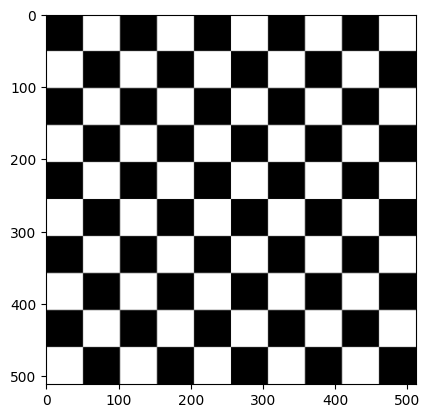

In [ ]:
# Import and resize corner regions.
# read in test image
image_url = "https://upload.wikimedia.org/wikipedia/commons/thumb/5/5b/10x10_checkered_board.svg/800px-10x10_checkered_board.svg.png"
image = url_to_image(image_url)

# Rescale & Crop Image
HW_trg =512
img_H = np.shape(image)[0]
img_W = np.shape(image)[1]
min_dim_size = min(img_H,img_W)
scale_fac = HW_trg/min_dim_size
scale_img_H = int(np.ceil(np.shape(image)[0]*scale_fac))
scale_img_W = int(np.ceil(np.shape(image)[1]*scale_fac))
rescale_image = cv2.resize(image, (scale_img_W,scale_img_H), interpolation = cv2.INTER_AREA)
crop_image = rescale_image[0:HW_trg, 0:HW_trg]
gray = cv2.cvtColor(crop_image, cv2.COLOR_BGR2GRAY)
plt.imshow(gray,'gray')

#Harris Algorithm (part 1)
In order to be able to form the components of the matrix M we will carry out the following steps:

1.   Create function(s) to output gradient (sobel or prewitt) kernels & (small) Gaussian kernel.
2.   Determine estimates of 1st order partial derivatives of the image $(\frac{\partial{I_{u,v}}}{\partial{x}},\frac{\partial{I_{u,v}}}{\partial{y}})$ by convolving the image with the gradient (sobel or prewitt) kernels.
3.    Obtain products of 1st order partial derivatives (e.g. $XY= \frac{\partial{I_{u,v}}}{\partial{x}} \frac{\partial{I_{u,v}}}{\partial{y}}$).
4.  Convolve the products of 1st order partial derivatives with the guassian kernel to obtain components of the second moment matrix $M = \begin{pmatrix}
A & C \\
C & B
\end{pmatrix}$ (e.g. $ A = X^2 \circledast W$).

Hints:
 * It is best to consistently use numpy methods (arrays) to complete this lab.
 * In order to define the [sobel](https://en.wikipedia.org/wiki/Sobel_operator) or [prewitt](https://en.wikipedia.org/wiki/Prewitt_operator) kernels, the [numpy array method](https://numpy.org/doc/stable/reference/generated/numpy.array.html) can be used (A 2D array will be required).
 *The gaussian kernel can be defined in exactly the same way as lab1_1A (i.e. creating a 1D array over a range of pixels and using outer product to create a 2D array)
 * In order to perform 2D convolution between the image (or other array) and the kernels, the [scipy convolve 2d](https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.convolve2d.html) method can be used.

In [ ]:
# 1. Functions to ouptut

def grad_kernel():
    #sobel kernel
    kernelx = np.array([[-1, 0, 1],
                        [-2, 0, 2],
                        [-1, 0, 1]])

    kernely = np.array([[-1, -2, -1],
                        [ 0,  0,  0],
                        [ 1,  2,  1]])
    return [kernelx,kernely]

def gauss_kernel(sigma):
    #1d gaus kernel
    rng = int(6*sigma + 1)
    x = np.arange(-rng, rng+1)
    gauss = np.exp(-x**2 / (2*sigma**2))
    gauss /= gauss.sum()

    M = (6 * sigma)+ 1
    print(M)

    x = np.arange(-M/2, M/2)

    # 1D Gaussian using the PDF equation
    gauss_1d = ( (1 / (sigma * np.sqrt(2 * np.pi)))) * (np.exp(-x**2 / (2 * sigma**2)) )

    #2d gaus kernel
    gauss_2d_kernel = np.outer(gauss_1d, gauss_1d)
    return gauss_2d_kernel


In [ ]:
# 2. Obtain estimates of parital derivatives of the image by convolution with sobel kernels
#### Your Code Here ####
# [5]
kernelx, kernely = grad_kernel()
dx = signal.convolve2d(gray, kernelx, mode='same',boundary='symm', fillvalue=0)
dy = signal.convolve2d(gray, kernely, mode='same',boundary='symm',fillvalue=0)
print("---------dx-----------")
print(dx)
print("--------dy------------")
print(dy)

---------dx-----------
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
--------dy------------
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


In [ ]:
# 3. Obtain products of 1st order partial derivatives.
#### Your Code Here ####
xx = dx**2
yy = dy**2
xy = dx*dy

print("--------xx------------")
print(xx)
print("--------yy------------")
print(yy)
print("--------xy------------")
print(xy)


--------xx------------
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
--------yy------------
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
--------xy------------
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


In [ ]:
# 4. Convlove products with Gaussian
# Determine Gaussian Kernel.
sigma = 2
gauss_2d_kernel = gauss_kernel(sigma)

#Convolve Products with Gaussian Kernel
#### Your Code Here ####
A = signal.convolve2d(xx, gauss_2d_kernel, mode='same', boundary='symm' ,fillvalue=0)
B = signal.convolve2d(yy, gauss_2d_kernel, mode='same', boundary='symm' ,fillvalue=0)
C = signal.convolve2d(xy, gauss_2d_kernel, mode='same', boundary='symm' ,fillvalue=0)

print("---------A-----------")
print(A)
print("--------B------------")
print(B)
print("--------C------------")
print(C)


13
---------A-----------
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
--------B------------
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
--------C------------
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


#Harris Algorithm (part2)

1. Find Corner Response Function $R=Det(M)-\alpha Trace(M)^2$. The corner response function is determined as the difference (with a scaling factor $\alpha$ between the Determinant and trace of the matrix M. As shown in the slides, the Determinat and Trace can be easily found from the elements of the matix $M$.
> $Det(M) = AB-C^2$

>> $Trace(M) = A+B$

2. Display the coner response function with the given code snippet. Ensure that the corner response function makes sense, do the maxima and minima appear where you expect them?

3. Mark corners on the original image.
 First a threshold value is used to remove the flat regions and edges found in the corner response.
The x,y coordinates of local maxima in the image are obtained using the peak_local_max method as shown in the [scikit learn example](https://scikit-image.org/docs/dev/auto_examples/segmentation/plot_peak_local_max.html).  The coordinates can be marked on the image.


In [ ]:
# 1. Obtain Corner response Function
alpha = 0.04

###  Your Code Here #####
detM = A*B - C**2
traceM = A+B

response_fun = detM - alpha * traceM**2

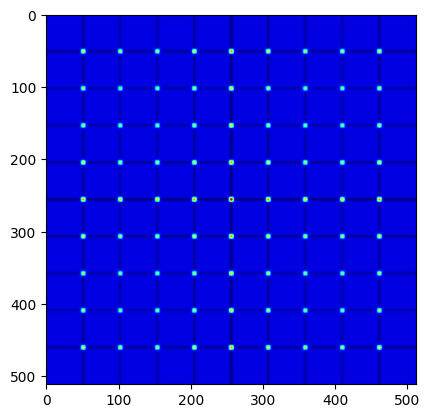

In [ ]:
# 2. Plot Corner response function
norm_response = response_fun+abs(np.min(response_fun))
norm_response = 255.0*norm_response/np.max(norm_response)
plt.imshow(norm_response,'jet')

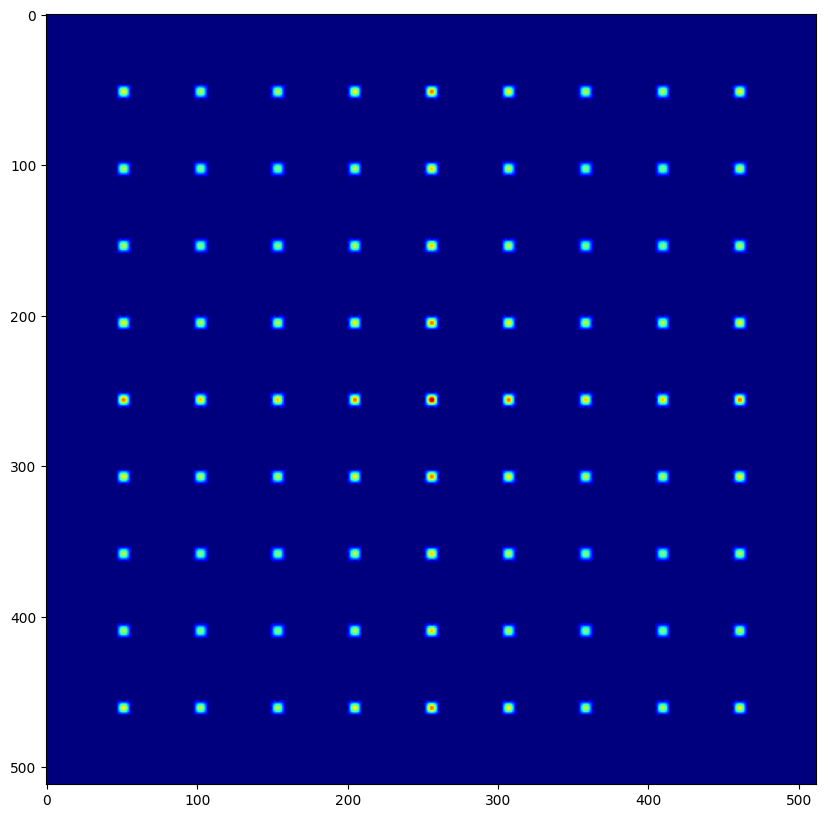

In [ ]:
#3a: Apply a threshold to normalised response
###  Your Code Here #####
threshold = 0.1 * norm_response.max()
thresholded_response = (norm_response > threshold) * norm_response

plt.figure(figsize=(10,10))
plt.imshow(thresholded_response,'jet')

In [ ]:
from skimage.feature import peak_local_max

# 3b: Find local maximum

###  Your Code Here #####

# Comparison between image_max and vals_greater_thresh to find the coordinates of local maxima

coordinates = peak_local_max(thresholded_response, min_distance=1)
# n x 2 array of coordinates

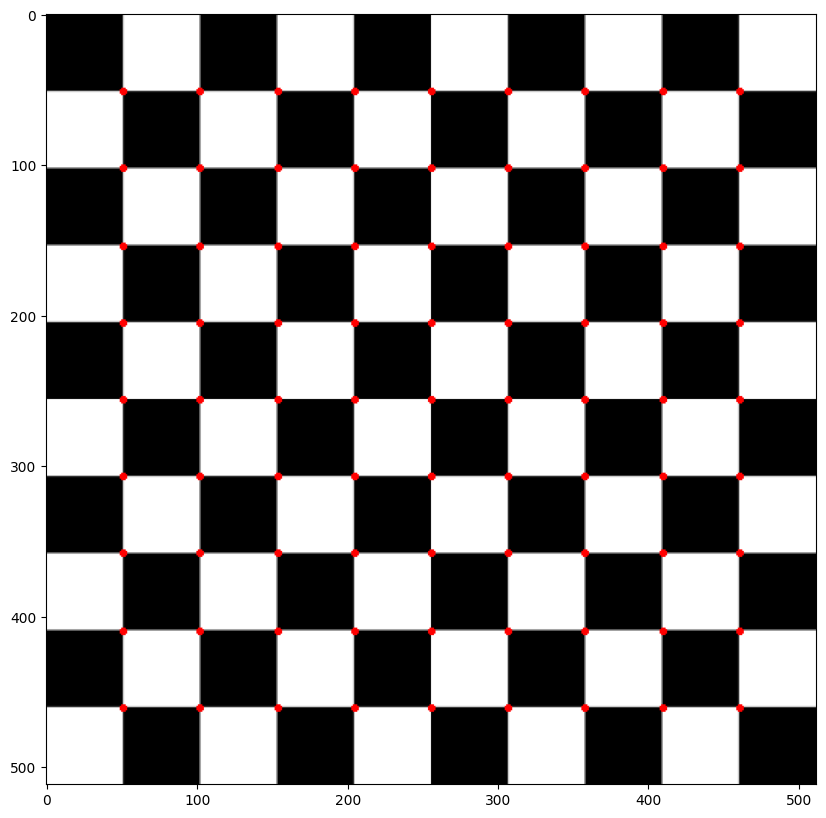

In [ ]:
# plot coordinates on original image
for xy_pos in coordinates:
   cv2.circle(crop_image, (xy_pos[1],xy_pos[0]), 1, (255,0,0),thickness=2)

plt.figure(figsize=(10,10))
plt.imshow(crop_image)